In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# import

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, random_split, DataLoader
import torch.nn.functional as F
from tqdm.auto import tqdm
from copy import deepcopy

import random
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import pickle

root = '/content/drive/MyDrive/Colab Notebooks/AF_pj/dataset/' # tutujin
# root = '/content/drive/MyDrive/Colab Notebooks/dataset/' # jin
# root = '/content/drive/MyDrive/Colab Notebooks/AF_dataset/' # 엄마
# root = '/content/drive/MyDrive/Project/dataset/' # 효정언니
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
def seedSet(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore
seedSet(1234)

In [ ]:
with open(root+'filled_train_data.pkl','rb') as fr:
    train_data = pickle.load(fr)
# train_data = {'aws':{'data' : data,
#                      'name_to_id' : regions_to_id,
#                      'id_to_name' : id_to_regions},
#               'pm':{'data' : pm_data,
#                     'name_to_id' : pm_to_id,
#                     'id_to_name' : id_to_pm}}
# columns_idx = 

In [ ]:
pm_name2id = train_data['pm']['name_to_id']
print(train_data['aws']['name_to_id'])
print(train_data['pm']['name_to_id'])
print(train_data['aws']['data'].shape, train_data['pm']['data'].shape)

{'계룡': 0, '공주': 1, '논산': 2, '당진': 3, '대산': 4, '대천항': 5, '북격렬비도': 6, '서천': 7, '성거': 8, '세종고운': 9, '세종금남': 10, '세종연서': 11, '세종전의': 12, '세천': 13, '아산': 14, '안도': 15, '양화': 16, '예산': 17, '오월드': 18, '옹도': 19, '유구': 20, '장동': 21, '정산': 22, '정안': 23, '청양': 24, '춘장대': 25, '태안': 26, '호도': 27, '홍북': 28, '홍성죽도': 29}
{'공주': 0, '노은동': 1, '논산': 2, '대천2동': 3, '독곶리': 4, '동문동': 5, '모종동': 6, '문창동': 7, '성성동': 8, '신방동': 9, '신흥동': 10, '아름동': 11, '예산군': 12, '읍내동': 13, '이원면': 14, '정림동': 15, '홍성읍': 16}
(35064, 30, 7) (35064, 17, 7)


In [ ]:
T, Ch, Co = train_data['pm']['data'].shape
pm_month_col = []
for pm_loc,id in train_data['pm']['name_to_id'].items():
    pm_df = pd.read_csv(root+'TRAIN/'+pm_loc+'.csv')
    pm_df.fillna(method='ffill', limit=10, inplace=True)
    pm_df.fillna(pm_df.mean(numeric_only=True), inplace=True)
    pm_month_col.append(pd.concat([pm_df['일시'].apply(lambda x: int(x.split('-')[0])),
                                   pm_df['PM2.5']], axis=1))
pm_month_col = np.array(pm_month_col).reshape(T, Ch, -1) 
train_arr = np.concatenate((train_data['pm']['data'], pm_month_col), axis=2)
print(pm_month_col.shape)
print(train_arr.shape)

(35064, 17, 2)
(35064, 17, 9)


In [ ]:
def dataSetting(root, array, fp='TRAIN', target_n=17):
    en_window_s = 2*24
    de_window_s = 3*24
    x_data, y_data = [], []
    for i in range(array.shape[0]-en_window_s-de_window_s):
        x_data.append(array[i:i+en_window_s])
        if fp=='TRAIN':
            idx = 0
            ys = array[i+en_window_s:i+en_window_s+de_window_s, :, idx] # idx: pm2.5의 칼럼 위치
            y_data.append(np.concatenate([np.zeros([1,ys.shape[1]]), ys], axis=0))
    x_data, y_data = np.array(x_data), np.array(y_data)
    if fp=='TRAIN': return x_data, y_data
    else: return x_data

x_train_data, y_train_data = dataSetting(root, train_arr, fp='TRAIN', target_n=17)
# x_test_data = dataSetting(root, test_arr, fp='TEST_INPUT', target_n=17)
print(x_train_data.shape, y_train_data.shape)
# print(x_test_data.shape)

(34944, 48, 17, 9) (34944, 73, 17)


In [ ]:
class myDataset(Dataset):
    def __init__(self, en_input, de_input=None):
        self.en_input, self.de_input = en_input, de_input

    def __len__(self):
        return len(self.en_input)
    
    def __getitem__(self, idx):
        encoder_input = torch.tensor(self.en_input[idx], dtype=torch.float32)
        if self.de_input is None: 
            return {'encoder_input':encoder_input}
        decoder_input = torch.tensor(self.de_input[idx], dtype=torch.float32)
        return {'encoder_input':encoder_input, 'decoder_input':decoder_input}

trainset = myDataset(x_train_data, y_train_data)
trainset, validset = random_split(trainset, [27955,6989])
# testset = myDataset(x_test_data)
print(len(trainset), len(validset))
# print(len(testset))

27955 6989


In [ ]:
batch_s = 128
trainloader = DataLoader(trainset, batch_size=batch_s, num_workers=1, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_s, num_workers=1, shuffle=False)
# testloader = DataLoader(testset, batch_size=batch_s, num_workers=1, shuffle=False)

print(len(trainloader), len(validloader))#, len(testloader))
batch = next(iter(trainloader))
print(batch['encoder_input'].shape, batch['decoder_input'].shape)
batch = next(iter(validloader))
print(batch['encoder_input'].shape, batch['decoder_input'].shape)
# batch = next(iter(testloader))
# print(batch['encoder_input'].shape)

219 55
torch.Size([128, 48, 17, 9]) torch.Size([128, 73, 17])
torch.Size([128, 48, 17, 9]) torch.Size([128, 73, 17])


# train

In [ ]:
# class run

In [ ]:
target_n = 17 # 맞춰야하는 관측소 pm2.5 수
n_layers = 3 # lstm 레이어 층
hidden_dim = 128 # lstm 히든차원
submit = pd.read_csv(root+'answer_sample.csv')
model = Seq2Seq(n_layers, hidden_dim, att=True, target_n=17)
# model.to(device)

  0%|          | 0/437 [00:00<?, ?it/s]

  0%|          | 0/437 [00:00<?, ?it/s]

  0%|          | 0/437 [00:00<?, ?it/s]

  0%|          | 0/437 [00:00<?, ?it/s]

  0%|          | 0/437 [00:00<?, ?it/s]

  0%|          | 0/437 [00:00<?, ?it/s]

Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.


  0%|          | 0/437 [00:00<?, ?it/s]

  0%|          | 0/437 [00:00<?, ?it/s]

  0%|          | 0/437 [00:00<?, ?it/s]

Epoch 00009: reducing learning rate of group 0 to 1.0000e-05.


  0%|          | 0/437 [00:00<?, ?it/s]

  0%|          | 0/437 [00:00<?, ?it/s]


Early Stopping!! epoch/epochs: 10/30


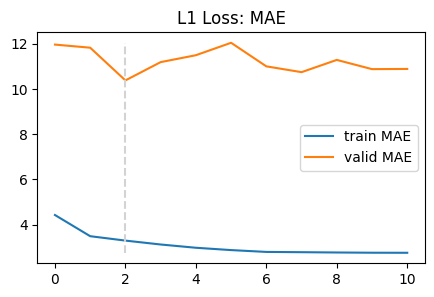

In [ ]:
# batch 128, lr 0.001, att=True
ver = 1
batch_s = 64
trainloader = DataLoader(trainset, batch_size=batch_s, num_workers=1, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_s, num_workers=1, shuffle=False)
# testloader = DataLoader(testset, batch_size=batch_s, num_workers=1, shuffle=False)
n_layers, hidden_dim, target_n = 3, 128, 17
model = Seq2Seq(n_layers, hidden_dim, att=True, dropout=0.2, target_n=17)
model = model.to(device)

lr = 0.001; epochs = 30; patience=7
loss_fn = nn.L1Loss() # MAE
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
fp = root+'/pretrained/0511_myrnn{}_'.format(ver)
myRNN1 = myTrain(trainloader, validloader, model, fp, pm_name2id, pm_max=70, earlystop=True)
myRNN1.train_loop(epochs, loss_fn, optimizer, scheduler, patience)
myRNN1.loss_plot()
# myRNN1.predict(model, testloader, submit, best_opt=True, last_opt=True)
# myRNN1.last_submit.to_csv(root+'/output/0511_myrnn{}_lastsubmit.csv'.format(ver), index=False)
# myRNN1.best_submit.to_csv(root+'/output/0511_myrnn{}_bestsubmit.csv'.format(ver), index=False)

In [ ]:
# testloader = DataLoader(testset, batch_size=batch_s, num_workers=1, shuffle=False)
# myRNN1.predict(model, testloader, submit, best_opt=True, last_opt=True)
# myRNN1.last_submit.to_csv(root+'/output/0511_myrnn{}_lastsubmit.csv'.format(ver), index=False)
# myRNN1.best_submit.to_csv(root+'/output/0511_myrnn{}_bestsubmit.csv'.format(ver), index=False)

  0%|          | 0/437 [00:00<?, ?it/s]

  0%|          | 0/437 [00:00<?, ?it/s]

  0%|          | 0/437 [00:00<?, ?it/s]

  0%|          | 0/437 [00:00<?, ?it/s]

  0%|          | 0/437 [00:00<?, ?it/s]

  0%|          | 0/437 [00:00<?, ?it/s]

  0%|          | 0/437 [00:00<?, ?it/s]

  0%|          | 0/437 [00:00<?, ?it/s]

  0%|          | 0/437 [00:00<?, ?it/s]

  0%|          | 0/437 [00:00<?, ?it/s]

  0%|          | 0/437 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7efeca795090>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7efeca795090>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

  0%|          | 0/437 [00:00<?, ?it/s]

Epoch 00012: reducing learning rate of group 0 to 5.0000e-05.


  0%|          | 0/437 [00:00<?, ?it/s]


Early Stopping!! epoch/epochs: 12/30


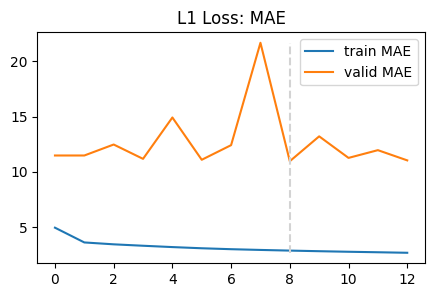

In [ ]:
# batch 64, lr 0.0005, att=True
ver = 2
batch_s = 64
trainloader = DataLoader(trainset, batch_size=batch_s, num_workers=1, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_s, num_workers=1, shuffle=False)
# testloader = DataLoader(testset, batch_size=batch_s, num_workers=1, shuffle=False)
n_layers, hidden_dim, target_n = 3, 128, 17
model = Seq2Seq(n_layers, hidden_dim, att=True, dropout=0.2, target_n=17)
model = model.to(device)

lr = 0.0005; epochs = 30; patience=7
loss_fn = nn.L1Loss() # MAE
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
fp = root+'/pretrained/0511_myrnn{}_'.format(ver)
myRNN2 = myTrain(trainloader, validloader, model, fp, pm_name2id, pm_max=70, earlystop=True)
myRNN2.train_loop(epochs, loss_fn, optimizer, scheduler, patience)
myRNN2.loss_plot()
# myRNN2.predict(model, testloader, submit, best_opt=True, last_opt=True)
# myRNN2.last_submit.to_csv(root+'/output/0511_myrnn{}_lastsubmit.csv'.format(ver), index=False)
# myRNN2.best_submit.to_csv(root+'/output/0511_myrnn{}_bestsubmit.csv'.format(ver), index=False)

In [ ]:
# testloader = DataLoader(testset, batch_size=batch_s, num_workers=1, shuffle=False)
# myRNN2.predict(model, testloader, submit, best_opt=True, last_opt=True)
# myRNN2.last_submit.to_csv(root+'/output/0511_myrnn{}_lastsubmit.csv'.format(ver), index=False)
# myRNN2.best_submit.to_csv(root+'/output/0511_myrnn{}_bestsubmit.csv'.format(ver), index=False)

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch 00007: reducing learning rate of group 0 to 5.0000e-05.


  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch 00013: reducing learning rate of group 0 to 5.0000e-06.


  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]


Early Stopping!! epoch/epochs: 14/30


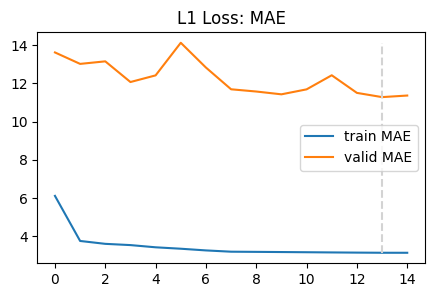

In [ ]:
# batch 128, lr 0.0005, att=True
ver = 3
batch_s = 128
trainloader = DataLoader(trainset, batch_size=batch_s, num_workers=1, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_s, num_workers=1, shuffle=False)
# testloader = DataLoader(testset, batch_size=batch_s, num_workers=1, shuffle=False)
n_layers, hidden_dim, target_n = 3, 128, 17
model = Seq2Seq(n_layers, hidden_dim, att=True, dropout=0.2, target_n=17)
model = model.to(device)

lr = 0.0005; epochs = 30; patience=7
loss_fn = nn.L1Loss() # MAE
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
fp = root+'/pretrained/0511_myrnn{}_'.format(ver)
myRNN3 = myTrain(trainloader, validloader, model, fp, pm_name2id, pm_max=70, earlystop=True)
myRNN3.train_loop(epochs, loss_fn, optimizer, scheduler, patience)
myRNN3.loss_plot()
# myRNN3.predict(model, testloader, submit, best_opt=True, last_opt=True)
# myRNN3.last_submit.to_csv(root+'/output/0511_myrnn{}_lastsubmit.csv'.format(ver), index=False)
# myRNN3.best_submit.to_csv(root+'/output/0511_myrnn{}_bestsubmit.csv'.format(ver), index=False)

In [ ]:
# testloader = DataLoader(testset, batch_size=batch_s, num_workers=1, shuffle=False)
# myRNN3.predict(model, testloader, submit, best_opt=True, last_opt=True)
# myRNN3.last_submit.to_csv(root+'/output/0511_myrnn{}_lastsubmit.csv'.format(ver), index=False)
# myRNN3.best_submit.to_csv(root+'/output/0511_myrnn{}_bestsubmit.csv'.format(ver), index=False)

  0%|          | 0/437 [00:00<?, ?it/s]

  0%|          | 0/437 [00:00<?, ?it/s]

  0%|          | 0/437 [00:00<?, ?it/s]

  0%|          | 0/437 [00:00<?, ?it/s]

  0%|          | 0/437 [00:00<?, ?it/s]

  0%|          | 0/437 [00:00<?, ?it/s]

  0%|          | 0/437 [00:00<?, ?it/s]

Epoch 00007: reducing learning rate of group 0 to 5.0000e-05.


  0%|          | 0/437 [00:00<?, ?it/s]

  0%|          | 0/437 [00:00<?, ?it/s]

  0%|          | 0/437 [00:00<?, ?it/s]

Epoch 00010: reducing learning rate of group 0 to 5.0000e-06.


  0%|          | 0/437 [00:00<?, ?it/s]


Early Stopping!! epoch/epochs: 10/30


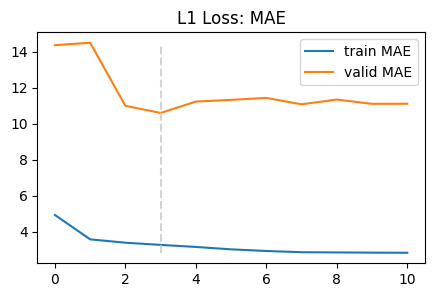

In [ ]:
# batch 64, lr 0.0005, att=True, dropout=0.15
ver = 4
batch_s = 64
trainloader = DataLoader(trainset, batch_size=batch_s, num_workers=1, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_s, num_workers=1, shuffle=False)
# testloader = DataLoader(testset, batch_size=batch_s, num_workers=1, shuffle=False)
n_layers, hidden_dim, target_n = 3, 128, 17
model = Seq2Seq(n_layers, hidden_dim, att=True, dropout=0.15, target_n=17)
model = model.to(device)

lr = 0.0005; epochs = 30; patience=7
loss_fn = nn.L1Loss() # MAE
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
fp = root+'/pretrained/0511_myrnn{}_'.format(ver)
myRNN4 = myTrain(trainloader, validloader, model, fp, pm_name2id, pm_max=70, earlystop=True)
myRNN4.train_loop(epochs, loss_fn, optimizer, scheduler, patience)
myRNN4.loss_plot()
# myRNN4.predict(model, testloader, submit, best_opt=True, last_opt=True)
# myRNN4.last_submit.to_csv(root+'/output/0511_myrnn{}_lastsubmit.csv'.format(ver), index=False)
# myRNN4.best_submit.to_csv(root+'/output/0511_myrnn{}_bestsubmit.csv'.format(ver), index=False)

In [ ]:
# testloader = DataLoader(testset, batch_size=batch_s, num_workers=1, shuffle=False)
# myRNN4.predict(model, testloader, submit, best_opt=True, last_opt=True)
# myRNN4.last_submit.to_csv(root+'/output/0511_myrnn{}_lastsubmit.csv'.format(ver), index=False)
# myRNN4.best_submit.to_csv(root+'/output/0511_myrnn{}_bestsubmit.csv'.format(ver), index=False)

# class

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, en_hidden_dim, n_layers, dropout):
        super().__init__()
        self.n_layers = n_layers
        self.en_hidden_dim = en_hidden_dim
        self.cnn1 = nn.Sequential(nn.Conv1d(input_dim, 50, 3, stride=1, padding=1),
                                  nn.SELU(),
                                  nn.Conv1d(50, 40, 3, stride=1, padding=1), 
                                  nn.BatchNorm1d(40), 
                                  nn.Dropout1d(dropout), nn.SELU(),
                                  nn.Conv1d(40, 30, 3, stride=1, padding=1), 
                                  nn.BatchNorm1d(30), nn.SELU(),
                                  nn.AvgPool1d(2, stride=2)) # 768,30,4
        self.cnn2 = nn.Sequential(nn.Conv1d(30,20,3, stride=1, padding=1),
                                  nn.BatchNorm1d(20), nn.SELU(),
                                  nn.Conv1d(20,17,3, stride=2, padding=1),
                                  nn.BatchNorm1d(17), nn.SELU(),
                                  nn.AvgPool1d(2, stride=2)) # 768,17,1
        self.lstm = nn.LSTM(input_dim, en_hidden_dim, n_layers, batch_first=True, dropout=dropout)
        
    def forward(self, en_input): # en_input: batch_s, times, channels, cols
        N,T,Ch,Co = en_input.shape # 16, 48, 17, 9
        en_input = en_input.reshape(N*T, Ch, Co) # 768, 17, 9
        cnn_output = self.cnn1(en_input) # 768, 30, 4
        cnn_output = self.cnn2(cnn_output) # 768, 17, 1
        cnn_output = cnn_output.reshape(N,T,-1) # 16, 48, 17
        en_hidden = self.init_hidden(N)
        en_output, en_hidden = self.lstm(cnn_output, en_hidden) # 16,48,128 / 3,16,128
        return en_output, en_hidden
    
    def init_hidden(self, batch_s):
        return (torch.zeros(self.n_layers, batch_s, self.en_hidden_dim, device=device),
               torch.zeros(self.n_layers, batch_s, self.en_hidden_dim, device=device))
        
class Attention(nn.Module):
    def __init__(self, en_hidden_dim, de_hidden_dim):
        super().__init__()
        self.fc_encoder = nn.Linear(en_hidden_dim, en_hidden_dim)
        self.fc_deinput = nn.Linear(de_hidden_dim, de_hidden_dim)
        self.scoring = nn.Linear(en_hidden_dim, 1)
        
    def forward(self, en_output, de_input):
        fc_en = self.fc_encoder(en_output) # 16,48,128
        fc_de = self.fc_deinput(de_input.unsqueeze(1)) # 16,1,128
        score = self.scoring(torch.tanh(fc_en+fc_de)) # 16,48,1
        att_w = torch.softmax(score, axis=1) # 16,48,1
        cont_v = att_w * en_output # 16,48,128
        cont_v = torch.sum(cont_v, dim=1) # 16,128
        return cont_v, att_w

class Decoder(nn.Module):
    def __init__(self, de_input_s, en_hidden_dim, de_hidden_dim, output_dim,
                 n_layers, dropout, att=False):
        super().__init__()
        self.n_layers, self.de_hidden_dim = n_layers, de_hidden_dim
        self.output_dim = output_dim
        if att:
            self.attention = Attention(en_hidden_dim=en_hidden_dim, de_hidden_dim=de_hidden_dim)
            self.lstm = nn.LSTM(en_hidden_dim*2, de_hidden_dim, n_layers, dropout=dropout)
        else: 
            self.attention = None
            self.lstm = nn.LSTM(en_hidden_dim, de_hidden_dim, n_layers, dropout=dropout)
        
        self.layer = nn.Linear(de_input_s, en_hidden_dim)
        # self.lstm = nn.LSTM(en_hidden_dim*2, de_hidden_dim, n_layers, dropout=dropout)
        self.fc = nn.Linear(de_hidden_dim, output_dim)
        
    def forward(self, en_output, de_input, de_hidden):
        N,_ = de_input.shape # 16,17
        de_input = self.layer(de_input) # 16,128
        if self.attention is not None:
            cont_v, att_w = self.attention(en_output, de_input)
            de_input = torch.cat([cont_v, de_input], dim=1) # 16,256
        de_input = de_input.unsqueeze(0) # 1,16,256
        de_hidden = self.init_hidden(N)
        de_output, de_hidden = self.lstm(de_input, de_hidden) # 1,16,128 / 3,16,128
        de_output = de_output.sum(0) # 16,128
        de_output = self.fc(de_output) # 16,17
        return de_output, de_hidden

    def init_hidden(self, batch_s):
        return (torch.zeros(self.n_layers, batch_s, self.de_hidden_dim, device=device),
               torch.zeros(self.n_layers, batch_s, self.de_hidden_dim, device=device))
        
class Seq2Seq(nn.Module):
    def __init__(self, n_layers, hidden_dim, att=False, dropout=0.2, target_n=17):
        super().__init__()
        self.encoder = Encoder(input_dim=target_n, en_hidden_dim=hidden_dim, n_layers=n_layers, dropout=dropout)
        self.decoder = Decoder(de_input_s=target_n, en_hidden_dim=hidden_dim, de_hidden_dim=hidden_dim,
                        output_dim=target_n, n_layers=n_layers, dropout=dropout, att=att)
        
    def forward(self, en_input, decoder_input, training=True):
        N,T,target_n = decoder_input.shape # 16,73,17
        outputs = torch.zeros(N, T-1, target_n).to(device) # 16,72,17
        en_output, en_hidden = self.encoder(en_input)
        de_input = decoder_input[:,0] # 16,17
        for t in range(0, T-1):
            if t==0: de_hidden = en_hidden
            de_output, de_hidden = self.decoder(en_output, de_input, de_hidden)
            outputs[:,t] = de_output # 16,17
            if training:
                de_input = decoder_input[:,t+1]
            else:
                de_input = de_output
        return outputs

In [ ]:
class myTrain():
    def __init__(self, trainloader, validloader, model, save_fp, pm_name2id, pm_max=70, earlystop=True, 
                 de_window_s=3*24, target_n=17):
        self.trainloader, self.validloader = trainloader, validloader
        self.model = model
        self.save_best_pth, self.save_last_pth = save_fp+'best_checkpoint.pth', save_fp+'last_checkpoint.pth'
        self.pm_name2id, self.pm_max = pm_name2id, pm_max
        self.earlystop = earlystop
        self.de_window_s, self.target_n = de_window_s, target_n

    def train_loop(self, epochs, loss_fn, optimizer, scheduler, patience):
        self.train_loss_li, self.valid_loss_li = [], []
        trigger = 0
        for epoch in range(epochs):
            self.model.train()
            train_loss = []
            train_tqdm = tqdm(self.trainloader)
            for batch in train_tqdm:
                encoder_input = batch['encoder_input'].to(device)
                decoder_input = batch['decoder_input'].to(device)
                output = self.model(encoder_input, decoder_input, training=True)
                loss = loss_fn(output, decoder_input[:,1:])
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss.append(loss.item())

                train_tqdm.set_postfix({'Epoch':epoch,
                                        'Loss':'{:.3f}'.format(train_loss[-1]*self.pm_max),
                                        'meanLoss':'{:.3f}'.format(np.mean(train_loss)*self.pm_max)})
            self.train_loss_li.append(np.mean(train_loss)*self.pm_max)
            self.valid_loss_li.append(self.validate(loss_fn)*self.pm_max)
            
            if np.min(self.valid_loss_li)==self.valid_loss_li[-1]:
                best_state = deepcopy(self.model.state_dict())
                torch.save(best_state, self.save_best_pth)
                self.best_epoch = epoch
                tigger = 0
            else:
                trigger += 1
                if self.earlystop:
                    if trigger>patience:
                        print('\nEarly Stopping!! epoch/epochs: {}/{}'.format(epoch, epochs))
                        break
            scheduler.step(self.valid_loss_li[-1])
            
        last_state = deepcopy(self.model.state_dict())
        torch.save(last_state, self.save_last_pth)

    def validate(self, loss_fn):
        self.valid_output = []
        self.model.eval()
        valid_loss = []
        # valid_tqdm = tqdm(self.validloader)
        valid_tqdm = self.validloader
        with torch.no_grad():
            for batch in valid_tqdm:
                encoder_input = batch['encoder_input'].to(device)
                decoder_input = batch['decoder_input'].to(device)
                output = self.model(encoder_input, decoder_input, training=False)
                loss = loss_fn(output, decoder_input[:,1:]).item()
                valid_loss.append(loss)
                # valid_tqdm.set_postfix({'ValidLoss':'{:.3f}'.format(valid_loss[-1]),
                #                         'meanValidLoss':'{:.3f}'.format(np.mean(valid_loss))})
                self.valid_output += output
        return np.mean(valid_loss)

    def loss_plot(self):
        fig, ax = plt.subplots(figsize=(5,3))
        ax.plot(self.train_loss_li, label='train MAE')
        ax.plot(self.valid_loss_li, label='valid MAE')
        ax.vlines(self.best_epoch, min(self.train_loss_li), max(self.valid_loss_li), colors='lightgray', linestyle='--')
        plt.title('L1 Loss: MAE'); plt.legend()
        plt.show()

    def evaluate(self, model, testloader, submit):
        model.eval()
        batch_s = next(iter(testloader))['encoder_input'].shape[0]
        preds = torch.zeros(batch_s*self.de_window_s, len(testloader), target_n)
        test_tqdm = tqdm(enumerate(testloader))
        with torch.no_grad():
            for i,batch in test_tqdm:
                encoder_input = batch['encoder_input'].to(device)
                decoder_input = torch.zeros([batch_s,self.de_window_s+1, target_n], dtype=torch.float32).to(device)
                output = model(encoder_input, decoder_input, training=False)
                preds[:,i] = output.view(-1, target_n)
        preds = preds.view(-1, target_n).cpu()
        for pm_loc, i in self.pm_name2id.items():
            submit.loc[submit['측정소']==pm_loc, 'PM2.5'] = preds[:,i].numpy().tolist()
        return submit 

    def predict(self, model, testloader, submit, best_opt=True, last_opt=True):
        if best_opt:
            best_dict = torch.load(self.save_best_pth)
            best_model = model
            best_model.load_state_dict(best_dict)
            self.best_submit = self.evaluate(best_model, testloader, submit)
        if last_opt:
            last_dict = torch.load(self.save_last_pth)
            last_model = model
            last_model.load_state_dict(last_dict)
            self.last_submit = self.evaluate(last_model, testloader, submit)